## Conjunto de datos

In [59]:
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# URL of where the training and testing samples are located
URL_TRAIN_DATA = "https://www.famaf.unc.edu.ar/~nocampo043/travel_insurance_prediction_train.csv"
URL_TEST_DATA = "https://www.famaf.unc.edu.ar/~nocampo043/travel_insurance_prediction_test.csv"

train_df = pd.read_csv(URL_TRAIN_DATA)
test_df = pd.read_csv(URL_TEST_DATA)

def save_predictions(model, test_id, X_test, filename):
    test_pred = model.predict(X_test)

    submission = pd.DataFrame(list(zip(test_id, test_pred)),
                              columns=["Customer", "TravelInsurance"])
    submission.to_csv(filename,
                      header=True,
                      index=False)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 22)

In [ ]:
train_df

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1,33,Private Sector/Self Employed,Yes,550000,6,0,No,No,1
1,2,28,Private Sector/Self Employed,Yes,800000,7,0,Yes,No,0
2,3,31,Private Sector/Self Employed,Yes,1250000,4,0,No,No,0
3,4,31,Government Sector,No,300000,7,0,No,No,0
4,5,28,Private Sector/Self Employed,Yes,1250000,3,0,No,No,0
...,...,...,...,...,...,...,...,...,...,...
1485,1486,31,Government Sector,No,300000,5,0,No,No,0
1486,1487,31,Private Sector/Self Employed,Yes,950000,3,0,Yes,No,0
1487,1488,28,Private Sector/Self Employed,Yes,1250000,5,0,No,No,0
1488,1489,31,Government Sector,Yes,1300000,5,0,No,No,0


In [ ]:
test_df

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,1491,29,Private Sector/Self Employed,Yes,1100000,4,0,No,No
1,1492,28,Private Sector/Self Employed,Yes,750000,5,1,Yes,No
2,1493,31,Government Sector,Yes,1500000,4,0,Yes,Yes
3,1494,28,Private Sector/Self Employed,Yes,1400000,3,0,No,Yes
4,1495,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes
...,...,...,...,...,...,...,...,...,...
492,1983,33,Government Sector,Yes,1750000,6,0,No,No
493,1984,25,Private Sector/Self Employed,No,1150000,3,1,No,No
494,1985,29,Private Sector/Self Employed,Yes,1050000,5,0,No,No
495,1986,25,Government Sector,Yes,750000,2,0,No,Yes


In [ ]:
# Delete customer id and separate target labels from the features
seed = 0
X_train_total = train_df.drop(["Customer","TravelInsurance"], axis=1)
y_train_total = train_df["TravelInsurance"]

X_train, X_val, y_train, y_val = train_test_split(X_train_total,
                                                  y_train_total,
                                                  test_size=0.2,
                                                  random_state=seed)

X_test = test_df.drop(["Customer"], axis=1)

In [ ]:
# Define pipeline that discretizes columns Age and AnnaulIncome, and encode the
# rest of variables using an ohe approach
preprocessor = ColumnTransformer(
    [("discretizer",
      KBinsDiscretizer(n_bins=16, encode="ordinal",
                       strategy="quantile"), ["Age", "AnnualIncome"]),
     ("encoder",
      OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"), [
          "Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer",
          "EverTravelledAbroad"
      ])],
    remainder="passthrough")

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


/home/benjamin/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/home/benjamin/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


## Modelo no automatizado

In [ ]:
from xgboost import XGBClassifier

parameters = {
    'alpha': 0.6066724149261147,
    'booster': 'gbtree',
    'colsample_bytree': 1.0,
    'eval_metric': 'logloss',
    'gamma': 1.0,
    'learning_rate': 1.0,
    'max_depth': 4,
    'n_estimators': 500,
    'objective': 'binary:logistic',
    'subsample': 1.0,
    'use_label_encoder': False,
}

clf = XGBClassifier(**parameters)

clf.fit(X_train, y_train)

y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)

print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       192
           1       0.92      0.57      0.70       106

    accuracy                           0.83       298
   macro avg       0.86      0.77      0.79       298
weighted avg       0.85      0.83      0.82       298



In [ ]:
X_train

array([[ 0., 10.,  0., ...,  1.,  0.,  0.],
       [ 9.,  8.,  0., ...,  1.,  0.,  1.],
       [ 6.,  1.,  1., ...,  1.,  0.,  0.],
       ...,
       [ 5.,  2.,  0., ...,  1.,  0.,  0.],
       [ 2., 14.,  0., ...,  1.,  0.,  0.],
       [ 1.,  3.,  0., ...,  1.,  0.,  0.]])

In [ ]:
X_test

array([[ 4.,  9.,  0., ...,  1.,  0.,  0.],
       [ 3.,  5.,  0., ...,  1.,  0.,  1.],
       [ 6., 14.,  1., ...,  0.,  1.,  0.],
       ...,
       [ 4.,  8.,  0., ...,  1.,  0.,  0.],
       [ 0.,  5.,  1., ...,  0.,  1.,  0.],
       [ 2.,  8.,  1., ...,  1.,  0.,  0.]])

In [ ]:
save_predictions(clf, test_df["Customer"], X_test, "xgb_no_automl.csv")

ValueError: Feature shape mismatch, expected: 19, got 8

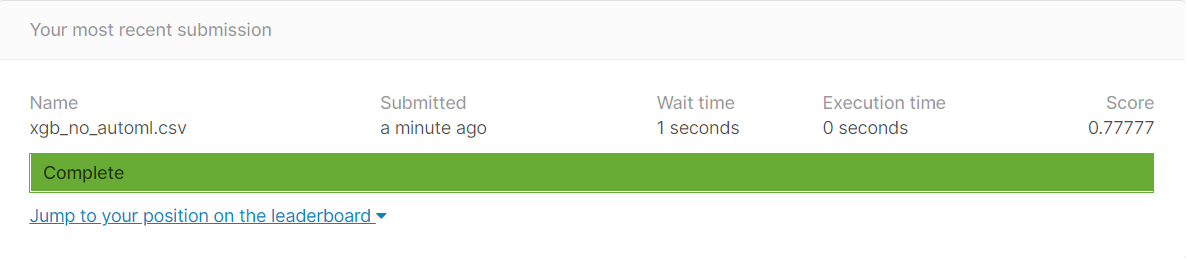

## Modelo con AutoML



In [ ]:
from autoPyTorch.api.tabular_classification import TabularClassificationTask

api = TabularClassificationTask(
    seed=42,
)

api.search(
    X_train=X_train,
    y_train=y_train,
    X_test=X_val.copy(),
    y_test=y_val.copy(),
    dataset_name='travel_insurance',
    optimize_metric='f1',
    total_walltime_limit=300,
    func_eval_time_limit_secs=50
)

y_pred = api.predict(X_val)
score = api.score(y_pred, y_val)
print(score)
print(api.show_models())
print(api.sprint_statistics())

[WARNING] [2021-12-05 10:50:09,455:Client-Validation] AutoPyTorch previously received features of type <class 'numpy.ndarray'> yet the current features have type <class 'pandas.core.frame.DataFrame'>. Changing the dtype of inputs to an estimator might cause problems
[WARNING] [2021-12-05 10:50:09,455:Client-Validation] AutoPyTorch previously received features of type <class 'numpy.ndarray'> yet the current features have type <class 'pandas.core.frame.DataFrame'>. Changing the dtype of inputs to an estimator might cause problems
[WARNING] [2021-12-05 10:50:09,495:Client-Validation] AutoPyTorch previously received features of type <class 'numpy.ndarray'> yet the current features have type <class 'pandas.core.frame.DataFrame'>. Changing the dtype of inputs to an estimator might cause problems
[WARNING] [2021-12-05 10:50:09,495:Client-Validation] AutoPyTorch previously received features of type <class 'numpy.ndarray'> yet the current features have type <class 'pandas.core.frame.DataFrame'>

/home/benjamin/miniconda3/envs/auto-pytorch/lib/python3.8/site-packages/smac-0.14.0-py3.8.egg/smac/intensification/parallel_scheduling.py:149: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/benjamin/miniconda3/envs/auto-pytorch/lib/python3.8/site-packages/smac-0.14.0-py3.8.egg/smac/intensification/parallel_scheduling.py:149: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/benjamin/miniconda3/envs/auto-pytorch/lib/python3.8/site-packages/smac-0.14.0-py3.8.egg/smac/intensification/parallel_scheduling.py:149: UserWarning: Hyperband is intended to be used with more than 1 worker but num_workers=1
  warnings.warn("{} is intended to be used "
/home/benjamin/miniconda3/envs/auto-pytorch/lib/python3.8/site-packages/smac-0.14.0-py3.8.egg/smac/intensification/parallel_scheduling.py:149: UserWarning: Hyperband is int

{'f1': 0.6203208556149732}
|    | Preprocessing                                                 | Estimator                                                       |   Weight |
|---:|:--------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | SimpleImputer,NoEncoder,Normalizer,TruncSVD                   | no embedding,MLPBackbone,FullyConnectedHead,nn.Sequential       |     0.32 |
|  1 | None                                                          | RFLearner                                                       |     0.2  |
|  2 | SimpleImputer,NoEncoder,StandardScaler,Nystroem               | no embedding,MLPBackbone,FullyConnectedHead,nn.Sequential       |     0.14 |
|  3 | SimpleImputer,NoEncoder,NoScaler,NoFeaturePreprocessing       | no embedding,MLPBackbone,FullyConnectedHead,nn.Sequential       |     0.08 |
|  4 | SimpleImputer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,S

In [ ]:
y_pred_val_automl = api.predict(X_val)
print(classification_report(y_val, y_pred_val_automl))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       192
           1       0.72      0.55      0.62       106

    accuracy                           0.76       298
   macro avg       0.75      0.71      0.72       298
weighted avg       0.76      0.76      0.75       298



In [ ]:
y_pred_test_automl = api.predict(X_test)

ValueError: Changing the column order of the features after fit() is not supported. Fit() method was called with [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] whereas the new features have ['Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad'] as type

In [ ]:
save_predictions(api, test_df["Customer"], X_test, "autopytorch.csv")